In [38]:
# Install Required libraries
!pip install swig
!pip install gym
!pip install gym[box2d]

In [39]:
# Import necessary libraries
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io
import numpy as np
from collections import deque, namedtuple

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

In [40]:
# Environment setup
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


In [41]:
# Neural Network for DQN
class NeuralQNetwork(nn.Module):
    """Q-Network for mapping state to action values."""

    def __init__(self, state_size, action_size, seed):
        """Initialize the network."""
        super(NeuralQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layer1 = nn.Linear(state_size, 64)
        self.layer2 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, action_size)

    def forward(self, state):
        """Forward pass for the network."""
        x = self.layer1(state)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        return self.output_layer(x)

In [42]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [44]:
# DQN Agent

class DQNAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object."""

        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.neuralqnetwork_local = NeuralQNetwork(state_size, action_size, seed).to(device)
        self.neuralqnetwork_target = NeuralQNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.neuralqnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        """Store experience and trigger learning."""
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Select an action using epsilon-greedy policy."""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.neuralqnetwork_local.eval()
        with torch.no_grad():
            action_values = self.neuralqnetwork_local(state)
        self.neuralqnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using a batch of experiences."""
        states, actions, rewards, next_states, dones = experiences

        #Compute Q targets
        q_targets_next = self.neuralqnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)


        ### Calculate Q expected
        q_expected = self.neuralqnetwork_local(states).gather(1, actions)

        ### Loss calculation (Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target network
        self.soft_update(self.neuralqnetwork_local, self.neuralqnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters."""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [45]:
class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object."""
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [46]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning."""
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.neuralqnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

agent = DQNAgent(state_size=8, action_size=4, seed=0)
scores = dqn()

Episode 100	Average Score: -164.29
Episode 200	Average Score: -113.19
Episode 300	Average Score: -49.61
Episode 400	Average Score: -16.79
Episode 500	Average Score: 129.39
Episode 551	Average Score: 200.98
Environment solved in 451 episodes!	Average Score: 200.98


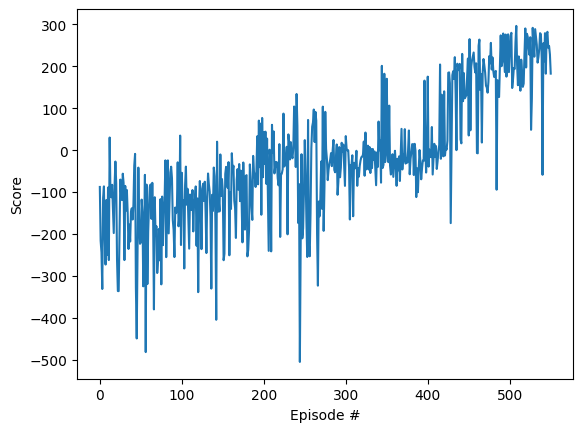

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [48]:
import os
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(agent, env_name):
    os.makedirs("video", exist_ok=True)  # Create 'video' directory if it doesn't exist
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    agent.neuralqnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()

        action = agent.act(state)

        state, reward, done, _ = env.step(action)
    vid.close()  # Close the video recorder
    env.close()

agent = DQNAgent(state_size=8, action_size=4, seed=0)
show_video_of_model(agent, 'LunarLander-v2')
show_video('LunarLander-v2')
